# Продвинутое машинное обучение: 
Домашнее задание 2

Студент: Чepникoв Дмитрий

Задача: построить вероятностную рейтинг-систему для спортивного “Что? Где? Когда?” (ЧГК).

https://rating.chgk.info/


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

from scipy.stats import spearmanr, kendalltau

from tqdm import tqdm
from os import listdir, path

In [2]:
display(sorted(listdir('./data')))

['.ipynb_checkpoints',
 'biases.csv',
 'players-release-2020-01-02.csv',
 'players-release-2020-12-25.csv',
 'players.pkl',
 'results.pkl',
 'test.csv',
 'tournaments.pkl',
 'train.csv',
 'weights.csv']

# Ввод и анализ данных

1.Прочитайте и проанализируйте данные, выберите турниры,в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl).

In [3]:
with open('./data/tournaments.pkl', 'rb') as f:
    raw_tournaments = pd.read_pickle(f)
    
with open('./data/results.pkl', 'rb') as f:
    raw_results = pd.read_pickle(f)
    
display(f'Raw tournaments: {len(raw_tournaments)}')
display(f'Raw results:     {len(raw_results)}')

'Raw tournaments: 5528'

'Raw results:     5528'

In [4]:
def parse_tournaments(tournaments, dateStart):
    columns = [
        'id',
        'name',
        'type',
        'typeId',
        'dateStart',
        'dateEnd',
        'questionsTotal',
    ]
    
    data = []
    for tournament in tqdm(tournaments.values()):
        if dateStart and tournament['dateStart'] > dateStart:
            data.append([
                tournament['id'],
                tournament['name'],
                tournament['type']['name'] if tournament['type'] else np.nan,
                tournament['type']['id'] if tournament['type'] else np.nan,
                tournament['dateStart'],
                tournament['dateEnd'],
                sum(tournament['questionQty'].values()),
            ])
    return pd.DataFrame(data, columns=columns)

In [5]:
tournaments = parse_tournaments(raw_tournaments, '2019')
del raw_tournaments

display(tournaments.head(2))
display(tournaments.shape)
tournaments.describe(include='all').T.fillna('')

100%|██████████| 5528/5528 [00:00<00:00, 587242.93it/s]


,id,name,type,typeId,dateStart,dateEnd,questionsTotal
0,4628,Семь сорок,Синхрон,3,2020-12-30T16:00:00+03:00,2020-12-30T16:00:00+03:00,36
1,4772,Синхрон северных стран. Зимний выпуск,Синхрон,3,2019-01-05T19:00:00+03:00,2019-01-09T19:00:00+03:00,36


(1109, 7)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,1109.0,,,,5853.67358,373.345899,4628.0,5565.0,5860.0,6168.0,6485.0
name,1109.0,938,"Онлайн: 19:00 Не числом, а умением - 2 (NEW!)",6,,,,,,,
type,1109.0,5,Синхрон,556,,,,,,,
typeId,1109.0,,,,3.148783,1.709089,2.0,2.0,3.0,3.0,8.0
dateStart,1109.0,823,2020-12-30T19:00:00+03:00,7,,,,,,,
dateEnd,1109.0,851,2020-12-30T14:00:00+03:00,8,,,,,,,
questionsTotal,1109.0,,,,47.307484,33.140579,3.0,36.0,36.0,45.0,500.0


In [6]:
def team_results(results, tournamentIds):
    for idx in tournamentIds:
        rec = results[idx]
        for team in rec:
            yield idx, team

def parse_results(results, tournamentIds):
    columns = [
        'tournamentId',
        'teamId',
        'teamName',
        'position',
        'playerId',
        'playerName',
        'mask',
        'answersTotal',
        'maskLen',
        'maskSum',
    ]
    
    data = []
    for idx, team in tqdm(team_results(results, tournamentIds)):
        # пропускаем результаты без повопросного описания
        if 'mask' not in team or not team['mask']:
            continue
        mask = team['mask']

        # пропускаем результаты со снятыми вопросами
        if 'X' in mask:
            continue

        for member in team['teamMembers']:
            if len(member) == 0:
                continue
            player = member['player']

            data.append([
                idx,
                team['team']['id'],
                team['team']['name'],
                team['position'],
                player['id'],
                ' '.join(player[k] or '' for k in ['surname', 'name', 'patronymic']),
                mask,
                team['questionsTotal'],
                len(mask),
                sum(c == '1' for c in mask)
            ])
                
    df = pd.DataFrame(data, columns=columns) \
        .set_index('tournamentId')
    
    df['maskMaxLen'] = df.groupby(by='tournamentId')['maskLen'].max()
    df.reset_index(inplace=True)
    
    # пропускаем результаты с некорректными масками
    correct_masks = (df['maskLen'] == df['maskMaxLen']) & (df['answersTotal'] == df['maskSum'])
    df = df[correct_masks][columns[:-3]].copy()

    return df

In [7]:
results = parse_results(raw_results, tournaments['id'].values)
del raw_results

display(results.head(2))
display(results.shape)
results.describe(include='all').T.fillna('')

109721it [00:01, 57991.12it/s]


,tournamentId,teamId,teamName,position,playerId,playerName,mask
0,4772,45556,Рабочее название,1.0,6212,Выменец Юрий Яковлевич,111111111011111110111111111100010010
1,4772,45556,Рабочее название,1.0,18332,Либер Александр Витальевич,111111111011111110111111111100010010


(445734, 7)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tournamentId,445734.0,,,,5661.457596,337.865184,4772.0,5452.0,5740.0,5856.0,6456.0
teamId,445734.0,,,,51052.790588,23037.751309,2.0,44012.0,57676.0,68615.0,78494.0
teamName,445734.0,11602,МГТУ - Легионеры,1467,,,,,,,
position,445734.0,,,,180.023633,215.877514,1.0,31.0,95.5,240.5,1247.5
playerId,445734.0,,,,116555.099761,67367.636476,15.0,54537.0,124615.0,176493.0,224697.0
playerName,445734.0,61048,Мельникова Ольга Андреевна,235,,,,,,,
mask,445734.0,85238,000000000000000000000000000000000000,1001,,,,,,,


In [8]:
players = results[['playerId', 'playerName']] \
    .drop_duplicates() \
    .set_index('playerId')

display(players.shape)
players.sort_values(by='playerName')

(61588, 1)

,playerName
playerId,
189667,Ёжиков Александр
110048,Ёжикова Ирина Игоревна
189364,Ёзденир Надежда Ильинична
198877,Ёкубов Сохиб Тохирович
213996,Ёкубов Улугбек Зокиругли
...,...
215270,Ящук Леонид
191434,ван Вилген Диана
191455,ван Вилген Людмила


In [9]:
team_results = results[['tournamentId', 'teamId','teamName', 'position']] \
    .drop_duplicates() \
    .set_index('teamId') \
    .sort_values(by=['tournamentId', 'position', 'teamName']) \
    .reset_index()

display(team_results.shape)
team_results[team_results['position'] < 6].head(15)

(86628, 4)

,teamId,tournamentId,teamName,position
0,45556,4772,Рабочее название,1.0
1,58596,4772,Аутята,5.5
2,40931,4772,Здоровенный Я,5.5
3,47075,4772,Оператор Дамблдора,5.5
4,1030,4772,Сборная Бутана,5.5
5,53185,4772,Сербский мультфильм,5.5
6,68786,4772,Сцилла,5.5
7,5444,4772,Эйфью,5.5
8,4252,4772,Ять,5.5
231,69309,4973,Брют,1.5


In [10]:
questions = results[['tournamentId', 'teamId', 'position', 'playerId', 'mask']] \
    .merge(tournaments[['id', 'dateStart']], how='inner', left_on='tournamentId', right_on='id') \
    .drop(columns='id')

display(questions.head(3))
display(questions.shape)
questions.describe(include='all').T.fillna('')

,tournamentId,teamId,position,playerId,mask,dateStart
0,4772,45556,1.0,6212,111111111011111110111111111100010010,2019-01-05T19:00:00+03:00
1,4772,45556,1.0,18332,111111111011111110111111111100010010,2019-01-05T19:00:00+03:00
2,4772,45556,1.0,18036,111111111011111110111111111100010010,2019-01-05T19:00:00+03:00


(445734, 6)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tournamentId,445734.0,,,,5661.457596,337.865184,4772.0,5452.0,5740.0,5856.0,6456.0
teamId,445734.0,,,,51052.790588,23037.751309,2.0,44012.0,57676.0,68615.0,78494.0
position,445734.0,,,,180.023633,215.877514,1.0,31.0,95.5,240.5,1247.5
playerId,445734.0,,,,116555.099761,67367.636476,15.0,54537.0,124615.0,176493.0,224697.0
mask,445734.0,85238,000000000000000000000000000000000000,1001,,,,,,,
dateStart,445734.0,583,2019-10-17T00:01:00+03:00,9693,,,,,,,


In [11]:
# Обучающая выборка - турниры за 2019 год
questions2019 = questions[questions['dateStart'] < '2020'] \
    .drop(columns=['dateStart'])

# Проверочная выборка - турниры за 2020 год
questions2020 = questions[(questions['dateStart'] > '2020')& (questions['dateStart'] < '2021')] \
    .drop(columns=['dateStart'])

display((questions2019.shape, questions2020.shape))
questions2019[::10000].head()

((350475, 5), (95259, 5))

,tournamentId,teamId,position,playerId,mask
0,4772,45556,1.0,6212,111111111011111110111111111100010010
10000,4974,68299,631.0,131752,000111011111100000010000101000011000
20000,5010,61705,10.5,172973,111111110001001011011010101111110111
30000,5025,6088,134.0,20096,111100001001111101000001010100001001000010000000
40000,5071,62365,247.0,166831,100101100001011100010110100010101111


# Baseline-модель

2.Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков на основе повопросных результатов

In [12]:
# Повопросные результаты каждого игрока
def explode_mask(df):
    df = df.copy()
    display('splitting mask...')
    df['mask'] = df['mask'].apply(lambda x: [(i+1, int(c == '1')) for i, c in enumerate(x)])
    
    display('exploding mask...')
    df = df.explode('mask')
    
    display('making ids...')
    df['questionId'] = df['tournamentId'].apply(str)
    df['questionId'] += df['mask'].apply(lambda x: '#' + str(x[0]))
    df['answer'] = df['mask'].apply(lambda x: x[1])
    df.drop(columns=['mask'], inplace=True)
    return df

train = explode_mask(questions2019)
test = explode_mask(questions2020)

display((train.shape, test.shape))
train[::1000000].head()

'splitting mask...'

'exploding mask...'

'making ids...'

'splitting mask...'

'exploding mask...'

'making ids...'

((14782108, 6), (3761558, 6))

,tournamentId,teamId,position,playerId,questionId,answer
0,4772,45556,1.0,6212,4772#1,1
27777,5021,66711,341.5,140388,5021#29,0
52027,5110,53341,61.5,26261,5110#34,1
77441,5331,6936,39.5,32004,5331#8,0
102204,5425,69349,25.5,115510,5425#18,0


In [13]:
X_train = train[['playerId', 'questionId']]
X_test = test[['playerId', 'questionId']]

y_train = train['answer']
y_test = test['answer']

display(f'Train: {(X_train.shape, y_train.shape)}')
display(f'Test:  {(X_test.shape, y_test.shape)}')

'Train: ((14782108, 2), (14782108,))'

'Test:  ((3761558, 2), (3761558,))'

In [14]:
class ChgkRatingBaseModel(object):
    def __init__(self, verbose=False):
        self.TOP_RATING = 14000
        self.encoder = OneHotEncoder(handle_unknown='ignore')
        self.model = LogisticRegression(
            solver='sag', random_state=1, n_jobs=-1
        )
        self.verbose = verbose
        
    def weights(self):
        return self.model.coef_[0, :]
    
    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))
 
    def fit(self, X, y):
        if self.verbose:
            print(f'encoding...\ninput X: {X.shape}')
        X_enc = self.encoder.fit_transform(X)
        if self.verbose:
            print(f'encoded: {X_enc.shape}\nfitting...')
        self.model.fit(X_enc, y)
        if self.verbose:
            print(f'done')
        return self
    
    def predict(self, X):
        if self.verbose:
            print(f'encoding...\ninput X: {X.shape}')
        X_enc = self.encoder.transform(X)
        if self.verbose:
            print(f'encoded X: {X_enc.shape}\npredicting...')
        y = self.model.predict(X_enc)
        if self.verbose:
            print(f'done')
        return y
    
    def predict_proba(self, X):
        if self.verbose:
            print(f'encoding...\ninput X: {X.shape}')
        X_enc = self.encoder.transform(X)
        if self.verbose:
            print(f'encoded: {X_enc.shape}\npredicting...')
        y = self.model.predict_proba(X_enc)
        if self.verbose:
            print(f'done')
        return y
    
    def player_rating(self):
        num_players = len(self.encoder.categories_[0])
        data = pd.Series(self.model.coef_[0, : num_players], name='playerRating')
        # отрицательный и нулевой рейтинг это плохо, применим сигмоиду
        data = self.TOP_RATING * self.sigmoid(data)
        index = pd.Series(self.encoder.categories_[0], name='playerId')
        return data.set_axis(index).sort_values(ascending=False)
        
    def question_rating(self):
        num_players = len(self.encoder.categories_[0])
        data = pd.Series(self.model.coef_[0, num_players:], name='questionRating')
        data = self.TOP_RATING * self.sigmoid(data)
        index = pd.Series(self.encoder.categories_[0], name='questionId')
        return data.set_axis(index).sort_values(ascending=False)

In [15]:
base_model = ChgkRatingBaseModel(verbose=True)
base_model.fit(X_train, y_train)

encoding...
input X: (14782108, 2)
encoded: (14782108, 86172)
fitting...
done


Оценим качество предсказания на проверочной выборке, поскольку у нас бинарная классификация, используем log_loss

In [16]:
proba = base_model.predict_proba(X_test)
log_loss(y_test, proba[:,1])

encoding...
input X: (3761558, 2)
encoded: (3761558, 86172)
predicting...
done


0.7340844561133483

Построим рейтинг игроков

In [17]:
rating = base_model.player_rating() \
    .to_frame() \
    .join(players, how='inner', on='playerId') \
    .reset_index()
rating.head(20)

,playerId,playerRating,playerName
0,27403,13765.363048,Руссо Максим Михайлович
1,4270,13731.688312,Брутер Александра Владимировна
2,28751,13718.980223,Семушин Иван Николаевич
3,27822,13709.918048,Савченков Михаил Владимирович
4,30270,13681.990406,Спешков Сергей Леонидович
5,30152,13680.211915,Сорожкин Артём Сергеевич
6,87637,13635.776149,Саксонов Антон Владимирович
7,18036,13635.461137,Левандовский Михаил Ильич
8,20691,13633.587105,Мереминский Станислав Григорьевич
9,26089,13619.249173,Прокофьева Ирина Сергеевна


Сравним с рейтингом ЧГК по состоянию на 2 января 2020 года

https://rating.chgk.info/players.php?release=1430

In [18]:
top1000_2020 = pd.read_csv('./data/players-release-2020-01-02.csv')
rating20_20 = rating.head(20) \
    .merge(top1000_2020.head(20),
           how='left',
           left_on='playerId',
           right_on=top1000_2020.columns[0]
    )
display(rating20_20)
count20_20 = rating20_20[rating20_20[top1000_2020.columns[0]].notna()]
display(f'Количество игроков rating20 / топ20: {count20_20.shape[0]}')

,playerId,playerRating,playerName,ИД,Имя,Отчество,Фамилия,ИД базовой команды,Базовая команда,Место,Рейтинг
0,27403,13765.363048,Руссо Максим Михайлович,27403.0,Максим,Михайлович,Руссо,NaN,"Москва, Хельсинки, Санкт-Петербург, Самара, Мо...",5.0,14168.0
1,4270,13731.688312,Брутер Александра Владимировна,4270.0,Александра,Владимировна,Брутер,NaN,"Москва, Долгопрудный, Санкт-Петербург, Могилёв...",6.0,14166.0
2,28751,13718.980223,Семушин Иван Николаевич,28751.0,Иван,Николаевич,Семушин,NaN,"Москва, Долгопрудный, Санкт-Петербург, Киров, ...",2.0,14761.0
3,27822,13709.918048,Савченков Михаил Владимирович,27822.0,Михаил,Владимирович,Савченков,NaN,"Москва, Могилёв, Серпухов, Минск, Калининград,...",3.0,14747.0
4,30270,13681.990406,Спешков Сергей Леонидович,30270.0,Сергей,Леонидович,Спешков,NaN,"Москва, Пермь, Самара, Челябинск, Могилёв, Мин...",4.0,14708.0
5,30152,13680.211915,Сорожкин Артём Сергеевич,30152.0,Артём,Сергеевич,Сорожкин,NaN,"Москва, Долгопрудный, Санкт-Петербург, Калуга,...",1.0,14848.0
6,87637,13635.776149,Саксонов Антон Владимирович,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,18036,13635.461137,Левандовский Михаил Ильич,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,20691,13633.587105,Мереминский Станислав Григорьевич,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,26089,13619.249173,Прокофьева Ирина Сергеевна,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Количество игроков rating20 / топ20: 9'

In [19]:
rating100_top100 = rating.head(100) \
    .merge(top1000_2020.head(100),
           how='left',
           left_on='playerId',
           right_on=top1000_2020.columns[0]
    )
display(rating100_top100)
count100_100 = rating100_top100[rating100_top100[top1000_2020.columns[0]].notna()]
display(f'Количество игроков rating100 / топ100: {count100_100.shape[0]}')

,playerId,playerRating,playerName,ИД,Имя,Отчество,Фамилия,ИД базовой команды,Базовая команда,Место,Рейтинг
0,27403,13765.363048,Руссо Максим Михайлович,27403.0,Максим,Михайлович,Руссо,NaN,"Москва, Хельсинки, Санкт-Петербург, Самара, Мо...",5.0,14168.0
1,4270,13731.688312,Брутер Александра Владимировна,4270.0,Александра,Владимировна,Брутер,NaN,"Москва, Долгопрудный, Санкт-Петербург, Могилёв...",6.0,14166.0
2,28751,13718.980223,Семушин Иван Николаевич,28751.0,Иван,Николаевич,Семушин,NaN,"Москва, Долгопрудный, Санкт-Петербург, Киров, ...",2.0,14761.0
3,27822,13709.918048,Савченков Михаил Владимирович,27822.0,Михаил,Владимирович,Савченков,NaN,"Москва, Могилёв, Серпухов, Минск, Калининград,...",3.0,14747.0
4,30270,13681.990406,Спешков Сергей Леонидович,30270.0,Сергей,Леонидович,Спешков,NaN,"Москва, Пермь, Самара, Челябинск, Могилёв, Мин...",4.0,14708.0
...,...,...,...,...,...,...,...,...,...,...,...
95,90915,13415.511150,Яковлев Вадим Игоревич,90915.0,Вадим,Игоревич,Яковлев,46381.0,Разведка боём (Москва),20.0,13707.0
96,5328,13415.167097,Великов Дмитрий Вадимович,5328.0,Дмитрий,Вадимович,Великов,46381.0,Разведка боём (Москва),67.0,13048.0
97,72211,13414.356123,Подрядчикова Мария Владимировна,72211.0,Мария,Владимировна,Подрядчикова,46381.0,Разведка боём (Москва),57.0,13072.0
98,63529,13411.515329,Тарарыков Дмитрий Фёдорович,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Количество игроков rating100 / топ100: 45'

Baseline модель дала хороший результат, особенно в отношении первой пятерки игроков

# Оценка качества предсказания

3.Качество рейтинг-системы оценивается качеством предсказанийрезультатов турниров.

Предложите способ предсказать результаты нового турнирас известнымисоставами, но неизвестными вопросами, в виде ранжирования команд.

- считаем, что игроки дают или дают ответ на вопросы независимо друг от друга
- команда не может ответить на вопрос, когда ни один из игроков не может ответить на него

Вероятность команды ответить на вопрос будем считать через произведение вероятностей каждого игрока не ответить на вопрос:

$p_{team} = 1 - \prod (1 - p_{player})$.

In [20]:
def calc_player_rating(df, rating, proba, minQuestions=None):
    player_rating = df.copy()
    player_rating['proba'] = 1 - proba[:,1]
    if 'playerRating' in df.columns:
        player_rating = player_rating.drop(columns=['playerRating'])

    player_rating['playerRating'] = player_rating.merge(rating, how='left')['playerRating']
    
    # средний рейтинг по команде
    mean_rating = player_rating \
        .groupby(by=['tournamentId','teamId']) \
        .min()['playerRating'] \
        .reset_index() \
        .rename(columns={'playerRating': 'meanRating'})

    player_rating.loc[player_rating['playerRating'].isna(),['playerRating']] = \
        player_rating[player_rating['playerRating'].isna()].merge(mean_rating)['meanRating']

    # средний рейтинг по турниру
    mean_rating = player_rating \
        .groupby(by=['tournamentId']) \
        .min()['playerRating'] \
        .reset_index() \
        .rename(columns={'playerRating': 'meanRating'})

    player_rating.loc[player_rating['playerRating'].isna(),['playerRating']] = \
        player_rating[player_rating['playerRating'].isna()].merge(mean_rating)['meanRating']
    
    # минимальный рейтинг
    player_rating['playerRating'].fillna(player_rating['playerRating'].min(), inplace=True)

    # количество вопросов по каждому игроку
    player_questions = player_rating \
        .groupby(by=['playerId']) \
        .count()['questionId'] \
        .rename('questionsCount')

    player_rating = player_rating.merge(player_questions, how='left', left_index=True, right_index=True)
    
    # минимальное количество вопросов
    player_rating['questionsCount'].fillna(player_rating['questionsCount'].min(), inplace=True)

    # отсечка по количеству вопросов
    if minQuestions:
        player_rating = player_rating[player_rating['questionsCount'] >= minQuestions]

    return player_rating

test_player_rating = calc_player_rating(test, rating, proba)
test_player_rating.describe().T

,count,mean,std,min,25%,50%,75%,max
tournamentId,3761558.0,5976.269948,214.998410,5414.000000,5754.000000,5962.000000,6184.000000,6456.000000
teamId,3761558.0,53737.397198,23430.710425,2.000000,46022.000000,60015.000000,72545.000000,78489.000000
position,3761558.0,172.224804,215.921788,1.000000,27.500000,87.000000,227.000000,1109.500000
playerId,3761558.0,124024.192585,70843.165037,15.000000,59399.000000,133028.000000,190276.000000,224697.000000
answer,3761558.0,0.463464,0.498663,0.000000,0.000000,0.000000,1.000000,1.000000
proba,3761558.0,0.628202,0.211824,0.077835,0.459111,0.634824,0.831982,0.995697
playerRating,3761558.0,7682.184589,3600.528987,322.204835,4622.881310,8244.747909,10872.212873,13731.688312
questionsCount,3761558.0,38.119024,22.713898,36.000000,36.000000,36.000000,36.000000,1494.000000


Посчитаем корреляцию по каждой команде, усредненную по всем турнирам

In [21]:
def calc_team_rating(df):
    team_rating = df[['tournamentId', 'teamId', 'questionId', 'proba']] \
        .groupby(by=['tournamentId', 'teamId', 'questionId']) \
        .prod() \
        .groupby(by=['tournamentId', 'teamId']) \
        .mean() \
        .reset_index()

    # чем больше команда отвечает на вопросы, тем ближе ее позиция в 1 месту, но больше рейтинг
    #team_rating['proba'] = 1 - team_rating['proba']

    team_rating['rating'] = team_rating.groupby('tournamentId')['proba'].rank()
    team_rating['position'] = team_rating.merge(team_results, on=['tournamentId', 'teamId'])['position']

    scores = team_rating[['tournamentId', 'rating', 'position']] \
        .groupby(by=['tournamentId']) \
        .agg(list)

    scores['spearman_r'] = scores.apply(lambda x: spearmanr(x['position'], x['rating'])[0], axis=1)
    scores['kendall_tau'] = scores.apply(lambda x: kendalltau(x['position'], x['rating'])[0], axis=1)
    return team_rating, scores[['spearman_r', 'kendall_tau']].mean()

test_team_rating, base_model_scores = calc_team_rating(test_player_rating)
base_model_scores

spearman_r     0.768320
kendall_tau    0.611975
dtype: float64

Корреляция Спирмена порядка 0.7-0.8,а корреляция Кендалла — порядка 0.5-0.6 - все так

In [22]:
train['idx'] = LabelEncoder() \
    .fit_transform(train['teamId'].apply(str) + '#' + train['questionId'])
train.to_csv('./data/train.csv', index=False)

In [23]:
test['idx'] = LabelEncoder() \
    .fit_transform(test['teamId'].apply(str) + '#' + test['questionId'])
test.to_csv('./data/test.csv', index=False)

In [24]:
pd.DataFrame(base_model.weights(), columns=['weights']).to_csv('./data/weights.csv', index=False)

# EM-алгоритм

4.разработайте EM-схему для обучения этой модели.

Введем скрытые переменные - вероятности ответа $i$-го игрока на $j$-вопрос при условии, что команда ответила правильно на вопрос.

$z_{i,j} = P(player = 1 | team = 1)$

Дальше по схеме:
- на E-шаге пересчитываем вероятности

$P(player = 1 | team = 1) = 
\frac{P(team = 1 | player = 1) P(player = 1)}{P(team = 1)} = \frac{p_{player}}{1 - \prod (1 - p_{player})}$

- на M-шаге максимизируем правдоподобие с помощью одного шага градиентного спуска

In [25]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, StratifiedKFold

from scipy.stats import spearmanr, kendalltau

from tqdm import tqdm
from os import listdir, path

In [26]:
train = pd.read_csv('./data/train.csv')
train.index = train['idx']

X_train = train[['playerId', 'questionId']]
y_train = train['answer']
display(train.shape)
train.head(3)

(14782108, 7)

,tournamentId,teamId,position,playerId,questionId,answer,idx
idx,,,,,,,
535950,4772,45556,1.0,6212,4772#1,1,535950
535961,4772,45556,1.0,6212,4772#2,1,535961
535972,4772,45556,1.0,6212,4772#3,1,535972


In [27]:
test = pd.read_csv('./data/test.csv')
test.index = test['idx']

X_test = test[['playerId', 'questionId']]
y_test = test['answer']
display(test.shape)
test.head(3)

(3761558, 7)

,tournamentId,teamId,position,playerId,questionId,answer,idx
idx,,,,,,,
414321,5414,66120,1.0,18490,5414#1,1,414321
414332,5414,66120,1.0,18490,5414#2,1,414332
414343,5414,66120,1.0,18490,5414#3,1,414343


In [28]:
weights = pd.read_csv('./data/weights.csv')['weights']
weights.head(3)

0    0.760361
1    1.594248
2    1.124232
Name: weights, dtype: float64

In [29]:
class ChgkResultsEMModel(object):
    def __init__(self, weights=None, verbose=False):
        self.TOP_RATING = 14000
        self.encoder = OneHotEncoder(handle_unknown='ignore')
        self.weights_ = weights
        self.loss_ticks_ = []
        self.verbose = verbose
        
    def weights(self):
        return self.weights_

    def loss(self):
        return np.array(self.loss_ticks_)
    
    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))
 
    def e_step(self, X, weights, idx):
        # hidden prior (player by question)
        hidden = pd.Series(self.sigmoid(X @ weights), idx, name='hidden')
        # observable proba (team by question)
        proba = 1 - (1 - hidden).groupby(level=0).prod()
        # hidden posterior
        df = pd.merge(hidden.to_frame(), proba.rename('proba'), left_index=True, right_index=True)
        df['hidden'] /= df['proba']
        return df['hidden']
    
    def m_step(self, X, y, z, weights, lr=1):
        # log_loss gradient
        dz = y * (1 - z) - (1 - y) * z
        dw = -X.T.dot(dz) / X.shape[0]
        # gradient decision step
        return weights - lr * dw
    
    def em_fit(self, X, y, idx, lr_base, lr_steps, n_iters):
        self.loss_ticks_ = []
        w = self.weights_.copy()
        for i in tqdm(range(n_iters)):
            # e-step
            z = self.e_step(X, w, idx)
            # loss
            self.loss_ticks_.append(log_loss(y, z))
            # m-step
            lr = lr_base * 0.1**(i // (n_iters // lr_steps))
            w = self.m_step(X, y, z, w, lr)
        self.weights_ = w
        return self

    def fit(self, X, y, idx, lr_base=1, lr_steps=1, n_iters=50):
        if self.verbose:
            print(f'encoding...\ninput X: {X.shape}')
        X_enc = self.encoder.fit_transform(X)
        if self.verbose:
            print(f'encoded: {X_enc.shape}\nfitting...')
        if self.weights_ is None:
            self.weights_ = np.ones(shape=(X_enc.shape[1],)) / X_enc.shape[1]
        self.em_fit(X_enc, np.array(y), idx, 
                    lr_base=lr_base, 
                    lr_steps=lr_steps, 
                    n_iters=n_iters)
        if self.verbose:
            print(f'done')
        return self

    def predict(self, X):
        if self.verbose:
            print(f'encoding...\ninput X: {X.shape}')
        X_enc = self.encoder.transform(X)
        if self.verbose:
            print(f'encoded X: {X_enc.shape}\npredicting...')
        y = np.round(self.sigmoid(X_enc @ self.weights_), 0)
        if self.verbose:
            print(f'done')
        return y

    def predict_proba(self, X):
        if self.verbose:
            print(f'encoding...\ninput X: {X.shape}')
        X_enc = self.encoder.transform(X)
        if self.verbose:
            print(f'encoded: {X_enc.shape}\npredicting...')
        proba = self.sigmoid(X_enc @ self.weights_)
        if self.verbose:
            print(f'done')
        display(proba.shape)
        return np.vstack([1-proba, proba]).T
    
    def player_rating(self):
        num_players = len(self.encoder.categories_[0])
        data = pd.Series(self.weights_[:num_players], name='playerRating')
        # отрицательный и нулевой рейтинг это плохо, применим сигмоиду
        data = self.TOP_RATING * self.sigmoid(data)
        index = pd.Series(self.encoder.categories_[0], name='playerId')
        return data.set_axis(index).sort_values(ascending=False)
        
    def question_rating(self):
        num_players = len(self.encoder.categories_[0])
        data = pd.Series(self.weights_[num_players:], name='questionRating')
        data = self.TOP_RATING * self.sigmoid(-data)
        index = pd.Series(self.encoder.categories_[1], name='questionId')
        return data.set_axis(index).sort_values(ascending=False)

encoding...
input X: (14782108, 2)


  0%|          | 0/20 [00:00<?, ?it/s]

encoded: (14782108, 86172)
fitting...


100%|██████████| 20/20 [01:46<00:00,  5.30s/it]

done


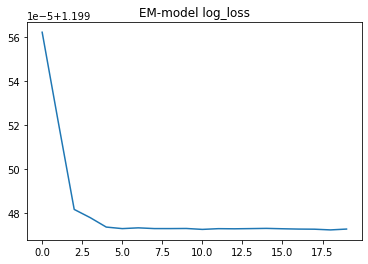

In [30]:
em_model = ChgkResultsEMModel(weights=weights, verbose=True)
em_model.fit(X_train, y_train, train.index, lr_base=5, lr_steps=10, n_iters=20)

plt.plot(em_model.loss())
plt.title('EM-model log_loss')
plt.show()

In [31]:
proba = em_model.predict_proba(X_test)
log_loss(y_test, proba[:,1])

encoding...
input X: (3761558, 2)
encoded: (3761558, 86172)
predicting...
done


(3761558,)

0.8350211745576381

In [32]:
rating = em_model.player_rating() \
    .to_frame() \
    .join(players, how='inner', on='playerId') \
    .reset_index()
rating.head(20)

,playerId,playerRating,playerName
0,27403,13765.389806,Руссо Максим Михайлович
1,4270,13731.737800,Брутер Александра Владимировна
2,28751,13719.039610,Семушин Иван Николаевич
3,27822,13709.944058,Савченков Михаил Владимирович
4,30270,13682.019944,Спешков Сергей Леонидович
5,30152,13680.272294,Сорожкин Артём Сергеевич
6,87637,13635.788182,Саксонов Антон Владимирович
7,18036,13635.458981,Левандовский Михаил Ильич
8,20691,13633.581772,Мереминский Станислав Григорьевич
9,26089,13619.254736,Прокофьева Ирина Сергеевна


In [33]:
top1000_2020 = pd.read_csv('./data/players-release-2020-01-02.csv')
rating20_20 = rating.head(20) \
    .merge(top1000_2020.head(20),
           how='left',
           left_on='playerId',
           right_on=top1000_2020.columns[0]
    )
display(rating20_20)
count20_20 = rating20_20[rating20_20[top1000_2020.columns[0]].notna()]
display(f'Количество игроков rating20 / топ20: {count20_20.shape[0]}')

,playerId,playerRating,playerName,ИД,Имя,Отчество,Фамилия,ИД базовой команды,Базовая команда,Место,Рейтинг
0,27403,13765.389806,Руссо Максим Михайлович,27403.0,Максим,Михайлович,Руссо,NaN,"Москва, Хельсинки, Санкт-Петербург, Самара, Мо...",5.0,14168.0
1,4270,13731.737800,Брутер Александра Владимировна,4270.0,Александра,Владимировна,Брутер,NaN,"Москва, Долгопрудный, Санкт-Петербург, Могилёв...",6.0,14166.0
2,28751,13719.039610,Семушин Иван Николаевич,28751.0,Иван,Николаевич,Семушин,NaN,"Москва, Долгопрудный, Санкт-Петербург, Киров, ...",2.0,14761.0
3,27822,13709.944058,Савченков Михаил Владимирович,27822.0,Михаил,Владимирович,Савченков,NaN,"Москва, Могилёв, Серпухов, Минск, Калининград,...",3.0,14747.0
4,30270,13682.019944,Спешков Сергей Леонидович,30270.0,Сергей,Леонидович,Спешков,NaN,"Москва, Пермь, Самара, Челябинск, Могилёв, Мин...",4.0,14708.0
5,30152,13680.272294,Сорожкин Артём Сергеевич,30152.0,Артём,Сергеевич,Сорожкин,NaN,"Москва, Долгопрудный, Санкт-Петербург, Калуга,...",1.0,14848.0
6,87637,13635.788182,Саксонов Антон Владимирович,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,18036,13635.458981,Левандовский Михаил Ильич,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,20691,13633.581772,Мереминский Станислав Григорьевич,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,26089,13619.254736,Прокофьева Ирина Сергеевна,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Количество игроков rating20 / топ20: 9'

In [34]:
rating100_top100 = rating.head(100) \
    .merge(top1000_2020.head(100),
           how='left',
           left_on='playerId',
           right_on=top1000_2020.columns[0]
    )
display(rating100_top100)
count100_100 = rating100_top100[rating100_top100[top1000_2020.columns[0]].notna()]
display(f'Количество игроков rating100 / топ100: {count100_100.shape[0]}')

,playerId,playerRating,playerName,ИД,Имя,Отчество,Фамилия,ИД базовой команды,Базовая команда,Место,Рейтинг
0,27403,13765.389806,Руссо Максим Михайлович,27403.0,Максим,Михайлович,Руссо,NaN,"Москва, Хельсинки, Санкт-Петербург, Самара, Мо...",5.0,14168.0
1,4270,13731.737800,Брутер Александра Владимировна,4270.0,Александра,Владимировна,Брутер,NaN,"Москва, Долгопрудный, Санкт-Петербург, Могилёв...",6.0,14166.0
2,28751,13719.039610,Семушин Иван Николаевич,28751.0,Иван,Николаевич,Семушин,NaN,"Москва, Долгопрудный, Санкт-Петербург, Киров, ...",2.0,14761.0
3,27822,13709.944058,Савченков Михаил Владимирович,27822.0,Михаил,Владимирович,Савченков,NaN,"Москва, Могилёв, Серпухов, Минск, Калининград,...",3.0,14747.0
4,30270,13682.019944,Спешков Сергей Леонидович,30270.0,Сергей,Леонидович,Спешков,NaN,"Москва, Пермь, Самара, Челябинск, Могилёв, Мин...",4.0,14708.0
...,...,...,...,...,...,...,...,...,...,...,...
95,90915,13415.436893,Яковлев Вадим Игоревич,90915.0,Вадим,Игоревич,Яковлев,46381.0,Разведка боём (Москва),20.0,13707.0
96,5328,13415.056539,Великов Дмитрий Вадимович,5328.0,Дмитрий,Вадимович,Великов,46381.0,Разведка боём (Москва),67.0,13048.0
97,72211,13414.321969,Подрядчикова Мария Владимировна,72211.0,Мария,Владимировна,Подрядчикова,46381.0,Разведка боём (Москва),57.0,13072.0
98,63529,13411.473697,Тарарыков Дмитрий Фёдорович,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Количество игроков rating100 / топ100: 45'

In [35]:
test_player_rating = calc_player_rating(test, rating, proba)
test_team_rating, em_model_scores = calc_team_rating(test_player_rating)
em_model_scores

spearman_r     0.742333
kendall_tau    0.586273
dtype: float64

In [36]:
display(base_model_scores, em_model_scores)

spearman_r     0.768320
kendall_tau    0.611975
dtype: float64

spearman_r     0.742333
kendall_tau    0.586273
dtype: float64

## Отсечка по количеству вопросов

100%|██████████| 15/15 [00:59<00:00,  3.94s/it]


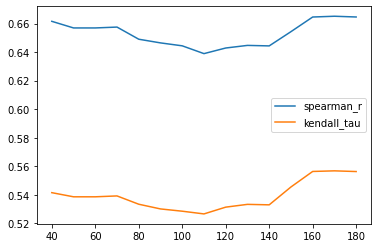

In [37]:
scores = []
ticks = np.linspace(40, 180, 15)
for i in tqdm(ticks):
    test_player_rating = calc_player_rating(test, rating, proba, i)
    test_team_rating, em_model_scores = calc_team_rating(test_player_rating)
    scores.append(em_model_scores)

pd.DataFrame(scores, index=ticks).plot()
plt.show()

## Результаты
Рейтинг не изменился, целевые метрики, чуть уменьшились, добиться их увеличения не удалось.

Если обучать EM-модель с одинаковыми начальными весами, точность предсказания уменьшается, т.е. качество предсказания повопросных результатов растет, но при этом целевые метрики в два раза ниже и отсечка не помогает.

encoding...
input X: (14782108, 2)


  0%|          | 0/20 [00:00<?, ?it/s]

encoded: (14782108, 86172)
fitting...


100%|██████████| 20/20 [01:51<00:00,  5.59s/it]

done


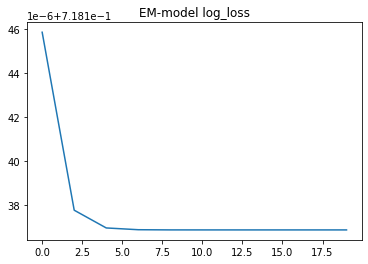

In [38]:
em_model0 = ChgkResultsEMModel(verbose=True)
em_model0.fit(X_train, y_train, train.index, lr_base=5, lr_steps=10, n_iters=20)

plt.plot(em_model0.loss())
plt.title('EM-model log_loss')
plt.show()

In [39]:
proba0 = em_model0.predict_proba(X_test)
log_loss(y_test, proba0[:,1])

encoding...
input X: (3761558, 2)
encoded: (3761558, 86172)
predicting...
done


(3761558,)

0.6931409943728056

In [40]:
rating = em_model0.player_rating() \
    .to_frame() \
    .join(players, how='inner', on='playerId') \
    .reset_index()

In [41]:
top1000_2020 = pd.read_csv('./data/players-release-2020-01-02.csv')
rating20_20 = rating.head(20) \
    .merge(top1000_2020.head(20),
           how='left',
           left_on='playerId',
           right_on=top1000_2020.columns[0]
    )
count20_20 = rating20_20[rating20_20[top1000_2020.columns[0]].notna()]
display(f'Количество игроков rating20 / топ20: {count20_20.shape[0]}')

rating100_top100 = rating.head(100) \
    .merge(top1000_2020.head(100),
           how='left',
           left_on='playerId',
           right_on=top1000_2020.columns[0]
    )
count100_100 = rating100_top100[rating100_top100[top1000_2020.columns[0]].notna()]
display(f'Количество игроков rating100 / топ100: {count100_100.shape[0]}')

'Количество игроков rating20 / топ20: 9'

'Количество игроков rating100 / топ100: 54'

In [42]:
test_player_rating = calc_player_rating(test, rating, proba0)
test_team_rating, em_model0_scores = calc_team_rating(test_player_rating)
em_model0_scores

spearman_r     0.358301
kendall_tau    0.266421
dtype: float64

In [43]:
display(base_model_scores, em_model_scores, em_model0_scores)

spearman_r     0.768320
kendall_tau    0.611975
dtype: float64

spearman_r     0.664603
kendall_tau    0.556301
dtype: float64

spearman_r     0.358301
kendall_tau    0.266421
dtype: float64

100%|██████████| 15/15 [01:02<00:00,  4.15s/it]


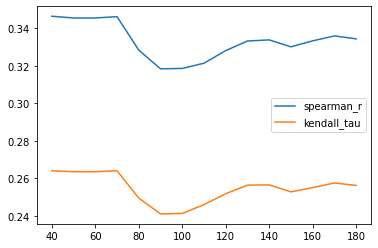

In [48]:
scores = []
ticks = np.linspace(40, 180, 15)
for i in tqdm(ticks):
    test_player_rating = calc_player_rating(test, rating, proba0, i)
    test_team_rating, em_model_scores = calc_team_rating(test_player_rating)
    scores.append(em_model_scores)

pd.DataFrame(scores, index=ticks).plot()
plt.show()

# Рейтинг турниров по сложности вопросов

In [49]:
questions_rating = train \
    .join(em_model.question_rating().to_frame(), how='inner', on='questionId') \
    .merge(tournaments[['id', 'name', 'type', 'typeId']],
          how='inner',
          left_on='tournamentId',
          right_on='id'
         )

tournament_rating = questions_rating[['tournamentId', 'name', 'type', 'questionRating']] \
    .groupby(by=['tournamentId', 'name', 'type']) \
    .mean() \
    .sort_values(by='questionRating',ascending=False)

Топ20 турниров с самыми сложными вопросами

In [50]:
tournament_rating.head(20)

,,,questionRating
tournamentId,name,type,
6149,Чемпионат Санкт-Петербурга. Первая лига,Обычный,13837.627205
5928,Угрюмый Ёрш,Синхрон,11890.576804
5159,Первенство правого полушария,Синхрон,11210.086121
6101,Воображаемый музей,Синхрон,11073.572819
5587,Записки охотника,Синхрон,11008.722871
5083,Ускользающая сова,Синхрон,10830.399101
5025,Кубок городов,Синхрон,10672.699163
5693,Знание – Сила VI,Синхрон,10655.553787
5515,Чемпионат Минска. Лига А. Тур четвёртый,Обычный,10631.108532


Топ20 турниров с самыми простыми вопросами

In [51]:
tournament_rating.tail(20).sort_values(by='questionRating')

,,,questionRating
tournamentId,name,type,
5013,(а)Синхрон-lite. Лига старта. Эпизод V,Асинхрон,1964.494371
5009,(а)Синхрон-lite. Лига старта. Эпизод III,Асинхрон,2240.170610
5698,(а)Синхрон-lite. Лига старта. Эпизод VII,Асинхрон,2434.965067
5936,Школьная лига. I тур.,Асинхрон,2470.465535
5702,(а)Синхрон-lite. Лига старта. Эпизод IX,Асинхрон,2494.255063
5012,Школьный Синхрон-lite. Выпуск 2.5,Асинхрон,2495.639498
6254,Школьная лига,Общий зачёт,2699.665716
5011,(а)Синхрон-lite. Лига старта. Эпизод IV,Асинхрон,2725.340708
5955,Школьная лига. III тур.,Асинхрон,2739.097173


Рейтинг лист турниров соответствует интуиции (по названию и типу турнира)